In [11]:
import pandas as pd
import numpy as np
import re
import nltk
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Dropout

In [12]:
# Load data
train_df = pd.read_csv('train.csv')

In [13]:
# Drop unwanted columns
train_df = train_df.drop(["author", "title", "id"], axis=1)

In [14]:
# Remove rows with missing values
train_df = train_df.dropna()

In [15]:
# Reset index
train_df.reset_index(drop=True, inplace=True)

In [16]:
# Lemmatization and removing stopwords
lemmatizer = WordNetLemmatizer()
stpwrds = set(stopwords.words('english'))

In [17]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [lemmatizer.lemmatize(word) for word in text if word not in stpwrds]
    return ' '.join(text)

In [18]:
train_df['text'] = train_df['text'].apply(preprocess_text)

In [19]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(train_df['text'], train_df['label'], test_size=0.2, random_state=0)

In [20]:
# TF-IDF Vectorization
tfidf_v = TfidfVectorizer(max_features=5000)
tfidf_X_train = tfidf_v.fit_transform(X_train)
tfidf_X_test = tfidf_v.transform(X_test)

In [22]:
# ANN model
ann_model = Sequential()
ann_model.add(Dense(units=128, activation='relu', input_shape=(tfidf_X_train.shape[1],)))
ann_model.add(Dropout(0.5))
ann_model.add(Dense(units=64, activation='relu'))
ann_model.add(Dropout(0.5))
ann_model.add(Dense(units=1, activation='sigmoid'))

C:\Users\91762\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Train the ANN model
ann_history = ann_model.fit(tfidf_X_train.toarray(), Y_train, epochs=2, batch_size=64, validation_split=0.2)

Epoch 1/2
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7677 - loss: 0.5008 - val_accuracy: 0.9374 - val_loss: 0.1566
Epoch 2/2
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9585 - loss: 0.1224 - val_accuracy: 0.9482 - val_loss: 0.1350


In [25]:
# Evaluate the ANN model
ann_Y_pred = (ann_model.predict(tfidf_X_test.toarray()) > 0.5).astype("int32")

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [26]:
# Classification report for ANN
print("Classification Report for ANN:")
print(classification_report(Y_test, ann_Y_pred))

Classification Report for ANN:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      2104
           1       0.95      0.94      0.94      2049

    accuracy                           0.95      4153
   macro avg       0.95      0.95      0.95      4153
weighted avg       0.95      0.95      0.95      4153



In [28]:
# Calculate confusion matrix for ANN
ann_cm = confusion_matrix(Y_test, ann_Y_pred)

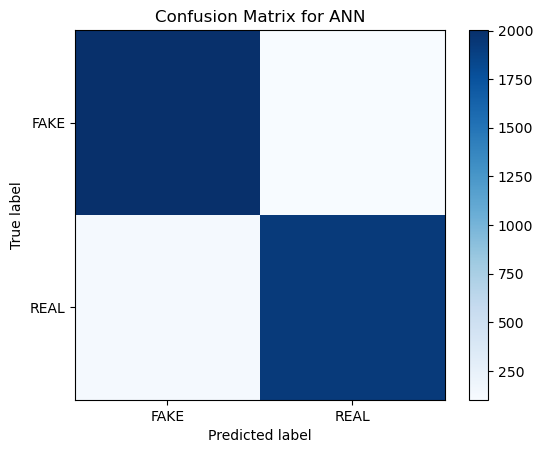

In [29]:
# Plot confusion matrix for ANN
import matplotlib.pyplot as plt
plt.figure()
plt.title('Confusion Matrix for ANN')
plt.imshow(ann_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['FAKE', 'REAL'])
plt.yticks(tick_marks, ['FAKE', 'REAL'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


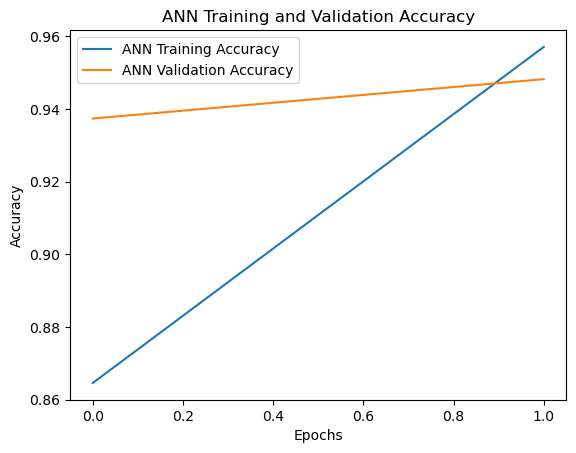

In [46]:
# Plot training and validation accuracy for ANN
plt.plot(ann_history.history['accuracy'], label='ANN Training Accuracy')
plt.plot(ann_history.history['val_accuracy'], label='ANN Validation Accuracy')
plt.title('ANN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
# RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=tfidf_X_train.shape[1]+1, output_dim=128))  # Using the input dimension directly
rnn_model.add(SpatialDropout1D(0.5))
rnn_model.add(LSTM(units=64, dropout=0.5, recurrent_dropout=0.5))
rnn_model.add(Dense(1, activation='sigmoid'))

In [18]:
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
# Train the RNN model with sparse representation
rnn_history = rnn_model.fit(tfidf_X_train, Y_train, epochs=2, batch_size=64, validation_split=0.2)

Epoch 1/2
208/208 ━━━━━━━━━━━━━━━━━━━━ 1077s 5s/step - accuracy: 0.5111 - loss: 0.6940 - val_accuracy: 0.4973 - val_loss: 0.6932
Epoch 2/2
208/208 ━━━━━━━━━━━━━━━━━━━━ 1108s 5s/step - accuracy: 0.4997 - loss: 0.6938 - val_accuracy: 0.5027 - val_loss: 0.6932


In [32]:
# Evaluate the RNN model
rnn_Y_pred = (rnn_model.predict(tfidf_X_test.toarray()) > 0.5).astype("int32")

130/130 ━━━━━━━━━━━━━━━━━━━━ 78s 590ms/step


In [ ]:
# Classification report for RNN
print("Classification Report for RNN:")
print(classification_report(Y_test, rnn_Y_pred))

In [34]:
rnn_cm = confusion_matrix(Y_test, rnn_Y_pred)

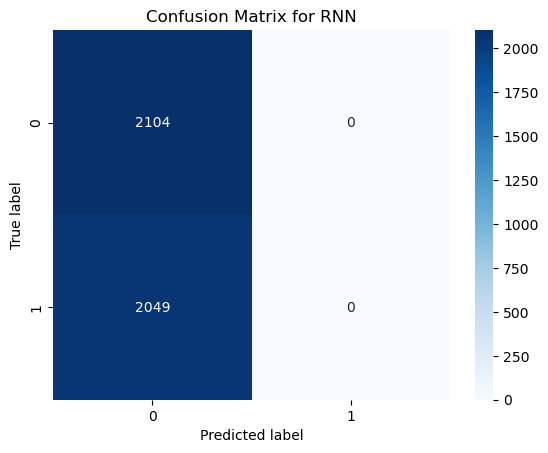

In [36]:
# Plot confusion matrix for RNN
import seaborn as sns
plt.title('Confusion Matrix for RNN')
sns.heatmap(rnn_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [47]:
# Plot training and validation accuracy for RNN
plt.plot(rnn_history.history['accuracy'], label='RNN Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Validation Accuracy')
plt.title('RNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'rnn_history' is not defined

In [1]:
from nltk.translate.bleu_score import sentence_bleu

# Example function to calculate BLEU score
def calculate_bleu_score(reference, hypothesis):
    return sentence_bleu([reference], hypothesis)

# Example usage
reference_text ='''Yes There Are Paid Government Trolls On Social Media, Blogs, Forums And Websites February 26th, 2014'''
hypothesis_text = "Generated text from the model."
bleu_score = calculate_bleu_score(reference_text, hypothesis_text)

print("BLEU Score:", bleu_score)


BLEU Score: 1.0695028554759082e-155


C:\ProgramData\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\ProgramData\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [40]:
from nltk.translate.bleu_score import sentence_bleu

# Flatten the list of lists into a single list
hypothesis_flat = [token for sublist in ann_Y_pred.tolist() for token in sublist]

# Calculate BLEU score
bleu_score_ann = sentence_bleu(reference_text, hypothesis_flat)

# Print the BLEU score
print("BLEU Score for ANN:", bleu_score_ann)


BLEU Score for ANN: 0


In [42]:
from nltk.translate.bleu_score import sentence_bleu

# Flatten the list of lists into a single list
hypothesis_flat = [token for sublist in ann_Y_pred.tolist() for token in sublist]

# Calculate BLEU score
bleu_score_rnn = sentence_bleu(reference_text, hypothesis_flat)

# Print the BLEU score
print("BLEU Score for RNN:", bleu_score_ann)


BLEU Score for RNN: 0


In [6]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Example training data
X = ["CSK win IPL", "Fake news about the election", "Real news about space"]
y = [1, 0, 1]  # 1 for real, 0 for fake

# Preprocess and vectorize the data
tfidf_v = TfidfVectorizer(max_features=5000)  # Use appropriate max_features based on your data
X_tfidf = tfidf_v.fit_transform(X)

# Train the model
model = PassiveAggressiveClassifier()
model.fit(X_tfidf, y)

# Save the model and vectorizer
with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_v, vectorizer_file)


In [9]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the model and vectorizer
with open('model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('vectorizer.pkl', 'rb') as vectorizer_file:
    tfidf_v = pickle.load(vectorizer_file)

def preprocess(news):
    # Implement your preprocessing steps if any
    return news

def predict_fake_news(news):
    preprocessed_news = preprocess(news)
    vectorized_news = tfidf_v.transform([preprocessed_news])
    prediction = model.predict(vectorized_news)[0]
    if prediction >0.5:
        return "Real News"
    else:
        return "Fake News"

# Example usage
news_article = "CSK win IPL in 2024."
prediction = predict_fake_news(news_article)
print("Prediction:", prediction)


Prediction: Real News
